In [1]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))

In [2]:
from argparse import Namespace
from data.bids_dataset import BidsDataset
from utils.brats_tools import temperature_scaled_softmax
import torch
from utils.brats_tools import plot_slices, get_central_slice
relu = torch.nn.ReLU()
softmax = torch.nn.Softmax(dim=0)
import numpy as np
from TPTBox import NII

In [3]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge'

In [4]:
def round_probs(probs,tolerance = 1000):
    return torch.round(probs*tolerance)/tolerance

In [5]:
def print_unique_etc(tensor):
    print(f"unique values in soft gt: {torch.unique(tensor)}")
    print(f"unique sums across all channels {torch.unique(tensor.sum(dim=0), return_counts=True)}") 

In [6]:
def l1_norm(probs):
    probs = probs / probs.sum(dim=0, keepdim=True)  # for tensor of shape (C, H, W, D), so without batch dim
    return probs

In [7]:
def exp_norm(probs, scaling_factor = 0.1):
    exp_tensor = torch.exp(scaling_factor * probs)
    probs = exp_tensor / exp_tensor.sum(dim = 0, keepdim = True)    # for tensor of shape (C, H, W, D), so without batch dim
    return probs

In [8]:
def relu_norm(logits):
    if bool(relu(logits).max()): # checking if the max value of the relu is not zero
        return relu(logits)/relu(logits).max()
    else: 
        return relu(logits)

In [9]:
def prob_normalization(probs, temperature, scaling_factor = 10):
    print(f"Temperature Softmaxed Probs")
    print_unique_etc(temperature_scaled_softmax(probs, temperature=temperature))
    print(f"---------------")
    print(f"L1 Normalized Probs")
    print_unique_etc(l1_norm(probs))
    print(f"---------------")
    print(f"Exponentially weighted normalized Probs")
    print_unique_etc(exp_norm(probs, scaling_factor))
    

# Sigma 0.125

## Pure

In [10]:
dilate = 0
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.125, do2D = False, soft=False, dilate=dilate, binary=False, ds_factor=None, experiment = 1)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [11]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

### Looking at unique values of soft Mask

In [145]:
# Without any processing
print_unique_etc(sample_soft_gt)

unique values in soft gt: tensor([0.0000e+00, 2.0305e-42, 4.0624e-42, 6.0928e-42, 8.1247e-42, 1.6038e-28,
        3.2076e-28, 4.8114e-28, 6.4152e-28, 8.0191e-28, 9.6229e-28, 1.1227e-27,
        1.2664e-14, 2.5328e-14, 3.7992e-14, 5.0657e-14, 6.3321e-14, 7.5985e-14,
        1.0000e+00])
unique sums across all channels (metatensor([1.]), metatensor([4202496]))


In [146]:
# Without any processing
print_unique_etc(sample_soft_gt.round(decimals=4))

unique values in soft gt: tensor([0., 1.])
unique sums across all channels (metatensor([1.]), metatensor([4202496]))


### Plots

#### Plot Hard GTs

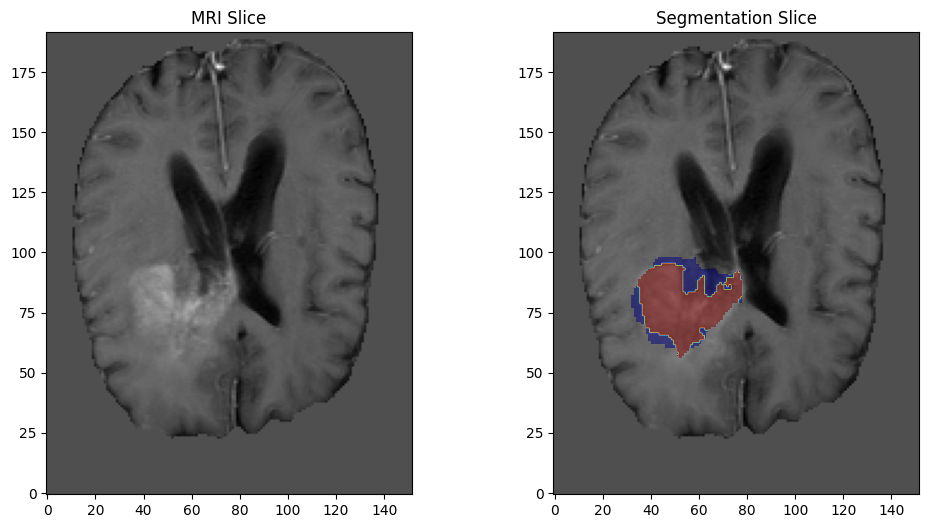

In [147]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

#### Plot Soft GTs

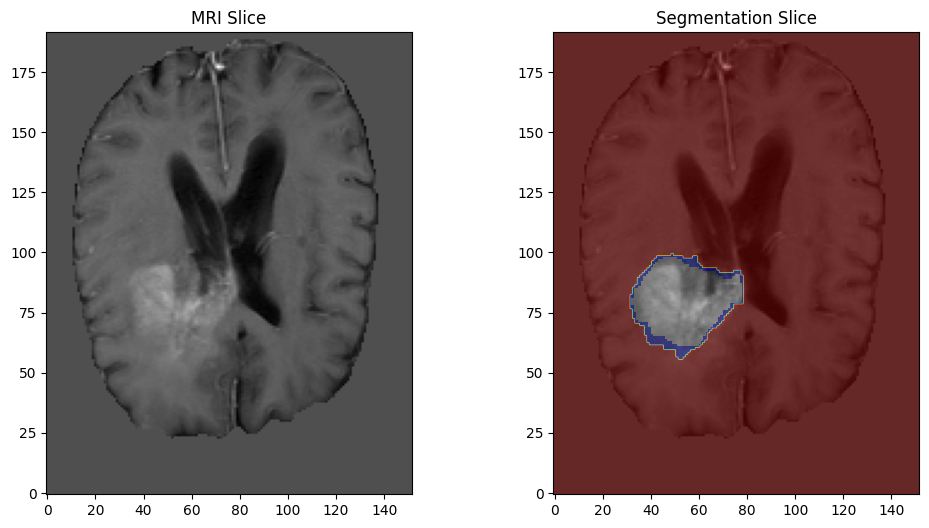

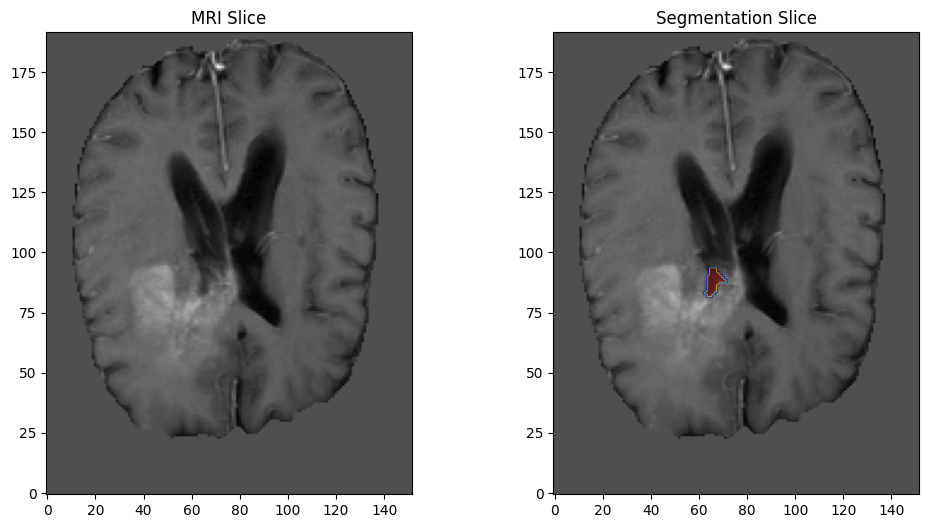

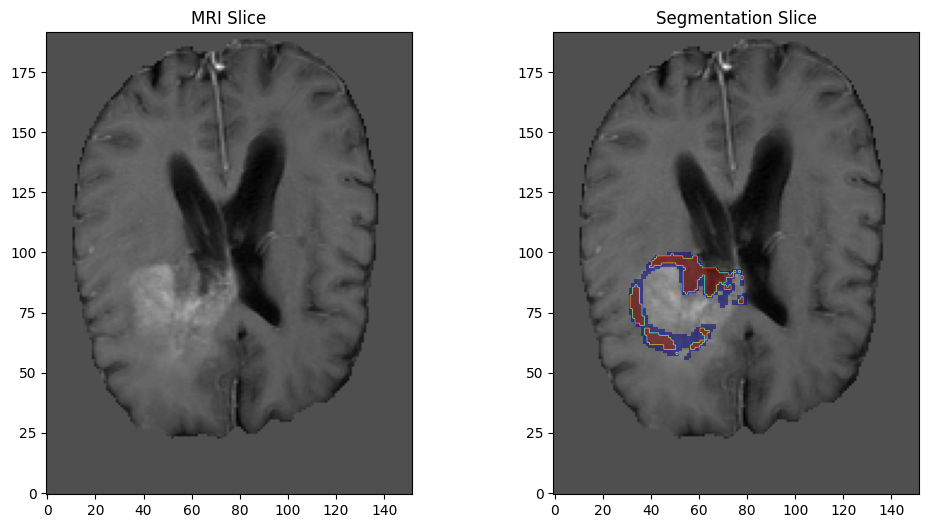

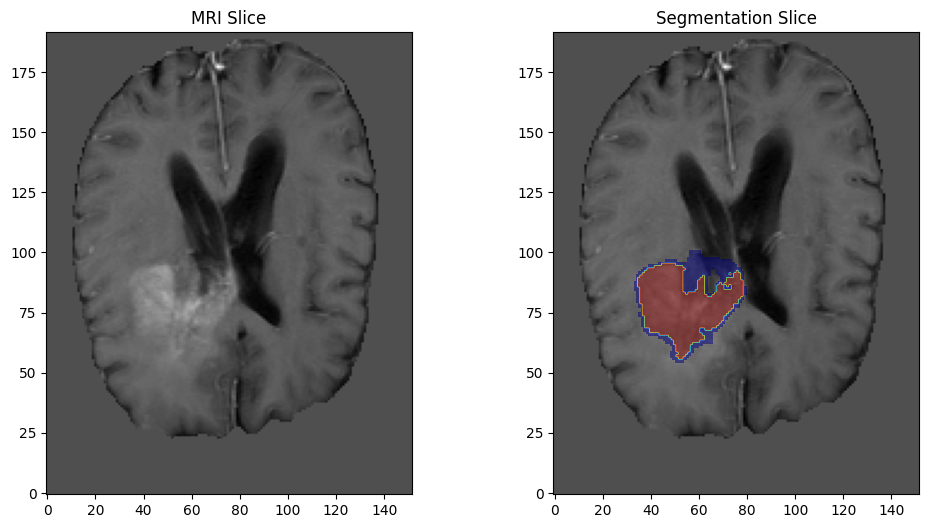

In [148]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[3], axis))

#### Plot Difference between GT and rebinarized Soft_GT

Unique Values and counts: (array([0, 2]), array([4065620,  136876]))
Difference NII (0: BG, 1: FN, 2: TP, 3: FP, 4: Wrong label)


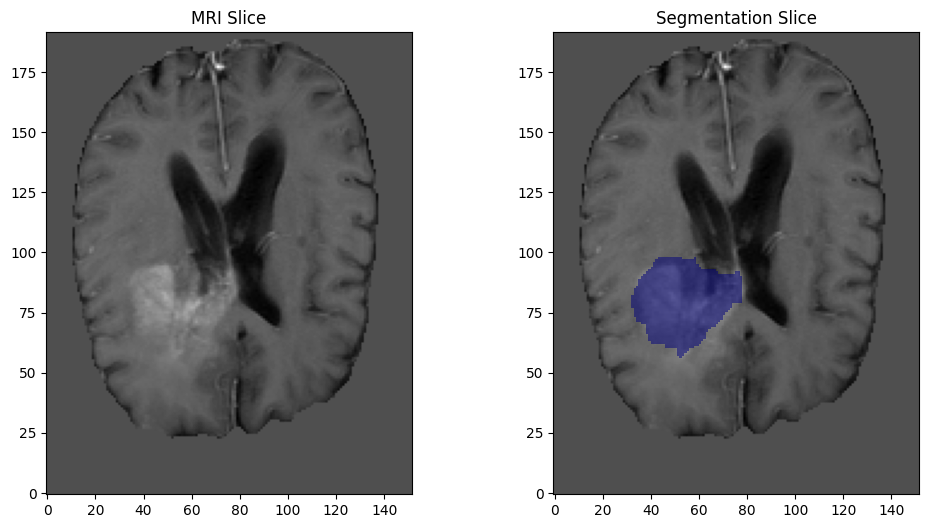

In [149]:
# load GT segmentation as NII object
gt_path = bids_ds.bids_list[0]['seg']
gt = NII.load(gt_path.with_suffix('.nii.gz'), seg=True)

gt : NII = gt.set_array(sample_gt.squeeze(0).numpy())

rebinarized_gt = torch.argmax(sample_soft_gt, dim = 0).numpy()
rebinarized_nii: NII = gt.set_array(rebinarized_gt)  # get prediction as nii object

difference_nifti = NII.get_segmentation_difference_to(rebinarized_nii, gt, ignore_background_tp=True)
difference_array = difference_nifti.get_array()
print(f"Unique Values and counts: {np.unique(difference_array, return_counts=True)}")
print("Difference NII (0: BG, 1: FN, 2: TP, 3: FP, 4: Wrong label)")
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(difference_array, axis))

In [150]:
# With rounding
print_unique_etc(sample_soft_gt.round(decimals=4))

print_unique_etc(sample_soft_gt.round(decimals=3))

print_unique_etc(sample_soft_gt.round(decimals=2))

unique values in soft gt: tensor([0., 1.])
unique sums across all channels (metatensor([1.]), metatensor([4202496]))
unique values in soft gt: tensor([0., 1.])
unique sums across all channels (metatensor([1.]), metatensor([4202496]))
unique values in soft gt: tensor([0., 1.])
unique sums across all channels (metatensor([1.]), metatensor([4202496]))


## with Normalization

### Norm ReLU

In [12]:
relu_soft_gt = relu_norm(sample_soft_gt)
print_unique_etc(relu_soft_gt)

unique values in soft gt: tensor([0.0000e+00, 2.0305e-42, 4.0624e-42, 6.0928e-42, 8.1247e-42, 1.6038e-28,
        3.2076e-28, 4.8114e-28, 6.4152e-28, 8.0191e-28, 9.6229e-28, 1.1227e-27,
        1.2664e-14, 2.5328e-14, 3.7992e-14, 5.0657e-14, 6.3321e-14, 7.5985e-14,
        1.0000e+00])
unique sums across all channels (metatensor([1.]), metatensor([4202496]))


# Sigma 0.25

## Pure

In [151]:
dilate = 0
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.25, do2D = False, soft=False, dilate=dilate, binary=False, ds_factor=None, experiment = 1)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [152]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

### Looking at unique values of soft Mask

In [153]:
# Without any processing
print_unique_etc(sample_soft_gt)

unique values in soft gt: tensor([0.0000e+00, 3.7675e-11, 7.5351e-11, 1.1303e-10, 1.5070e-10, 1.1231e-07,
        1.1235e-07, 1.1238e-07, 1.1242e-07, 1.1246e-07, 2.2462e-07, 2.2466e-07,
        2.2469e-07, 2.2473e-07, 2.2477e-07, 3.3693e-07, 3.3696e-07, 3.3700e-07,
        3.3704e-07, 3.3708e-07, 3.3712e-07, 3.3715e-07, 4.4924e-07, 4.4927e-07,
        4.4931e-07, 4.4935e-07, 4.4939e-07, 4.4942e-07, 5.6158e-07, 5.6162e-07,
        5.6166e-07, 5.6170e-07, 5.6173e-07, 5.6177e-07, 6.7389e-07, 6.7393e-07,
        6.7397e-07, 6.7400e-07, 6.7404e-07, 6.7408e-07, 7.8639e-07, 3.3479e-04,
        3.3479e-04, 3.3479e-04, 3.3479e-04, 3.3490e-04, 3.3490e-04, 3.3490e-04,
        3.3490e-04, 3.3501e-04, 3.3501e-04, 3.3501e-04, 3.3501e-04, 3.3501e-04,
        3.3513e-04, 3.3513e-04, 3.3513e-04, 3.3513e-04, 3.3513e-04, 3.3513e-04,
        3.3513e-04, 3.3524e-04, 3.3524e-04, 3.3524e-04, 3.3524e-04, 3.3524e-04,
        3.3524e-04, 3.3524e-04, 3.3535e-04, 3.3535e-04, 3.3535e-04, 3.3535e-04,
        3.3535

In [154]:
# Without any processing
print_unique_etc(sample_soft_gt.round(decimals=10))

unique values in soft gt: tensor([0.0000e+00, 1.0000e-10, 2.0000e-10, 1.1230e-07, 1.1240e-07, 1.1250e-07,
        2.2460e-07, 2.2470e-07, 2.2480e-07, 3.3690e-07, 3.3700e-07, 3.3710e-07,
        3.3720e-07, 4.4920e-07, 4.4930e-07, 4.4940e-07, 5.6160e-07, 5.6170e-07,
        5.6180e-07, 6.7390e-07, 6.7400e-07, 6.7410e-07, 7.8640e-07, 3.3479e-04,
        3.3479e-04, 3.3490e-04, 3.3490e-04, 3.3490e-04, 3.3501e-04, 3.3501e-04,
        3.3513e-04, 3.3513e-04, 3.3513e-04, 3.3513e-04, 3.3524e-04, 3.3524e-04,
        3.3524e-04, 3.3535e-04, 3.3535e-04, 3.3535e-04, 3.3546e-04, 3.3546e-04,
        3.3546e-04, 3.3557e-04, 3.3557e-04, 3.3557e-04, 3.3569e-04, 3.3580e-04,
        6.6958e-04, 6.6958e-04, 6.6958e-04, 6.6969e-04, 6.6969e-04, 6.6980e-04,
        6.6980e-04, 6.6980e-04, 6.6991e-04, 6.6991e-04, 6.7003e-04, 6.7003e-04,
        6.7014e-04, 6.7014e-04, 6.7014e-04, 6.7025e-04, 6.7025e-04, 6.7025e-04,
        6.7036e-04, 6.7036e-04, 6.7036e-04, 6.7036e-04, 6.7048e-04, 6.7048e-04,
        6.7048

### Plots

#### Hard GTs

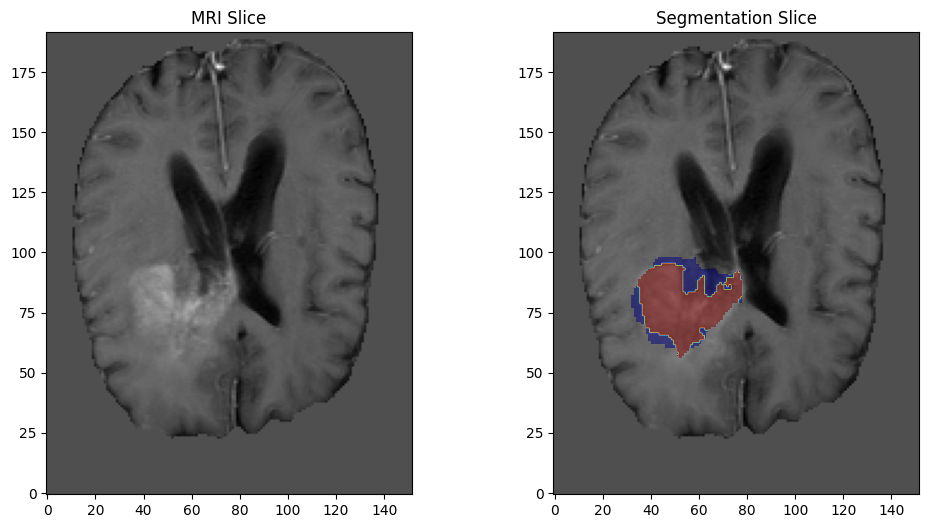

In [155]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

#### Plot Soft GTs

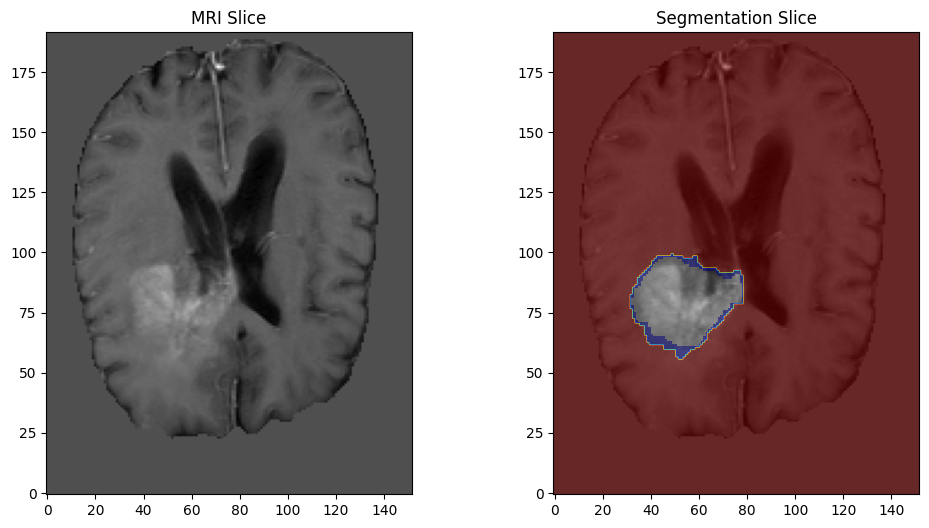

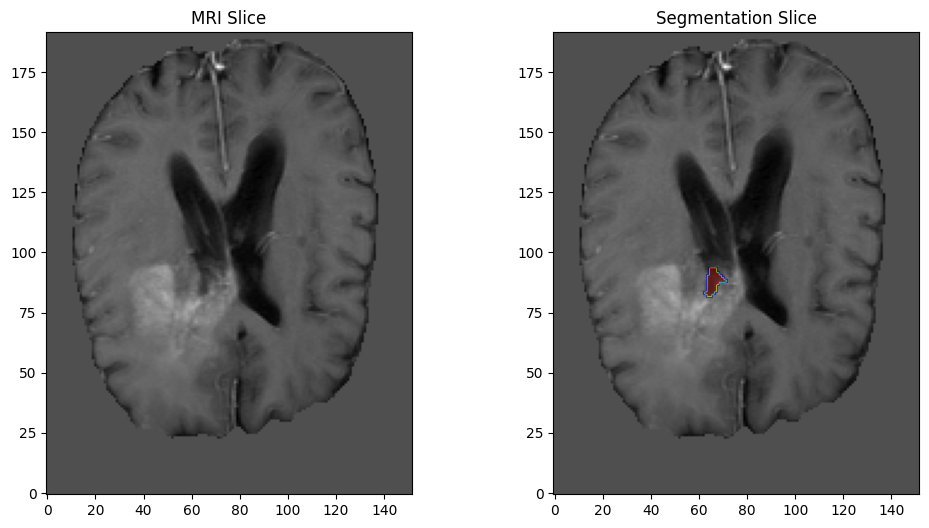

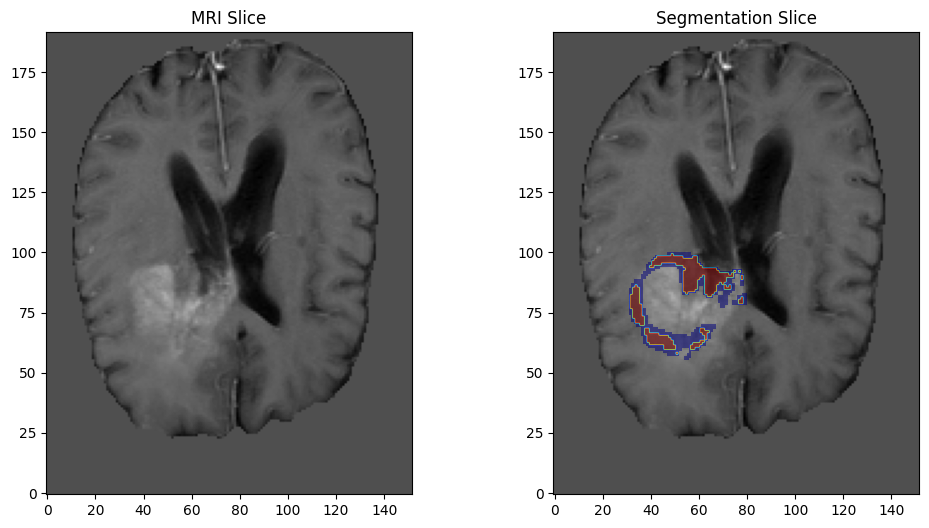

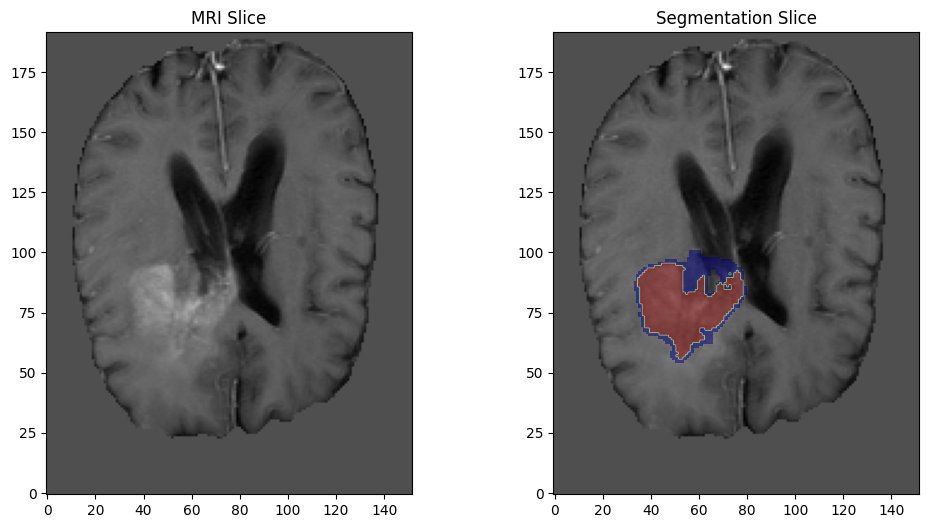

In [156]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[3], axis))

#### Plot Difference between GT and rebinarized Soft_GT

Unique Values and counts: (array([0, 2]), array([4065620,  136876]))
Difference NII (0: BG, 1: FN, 2: TP, 3: FP, 4: Wrong label)


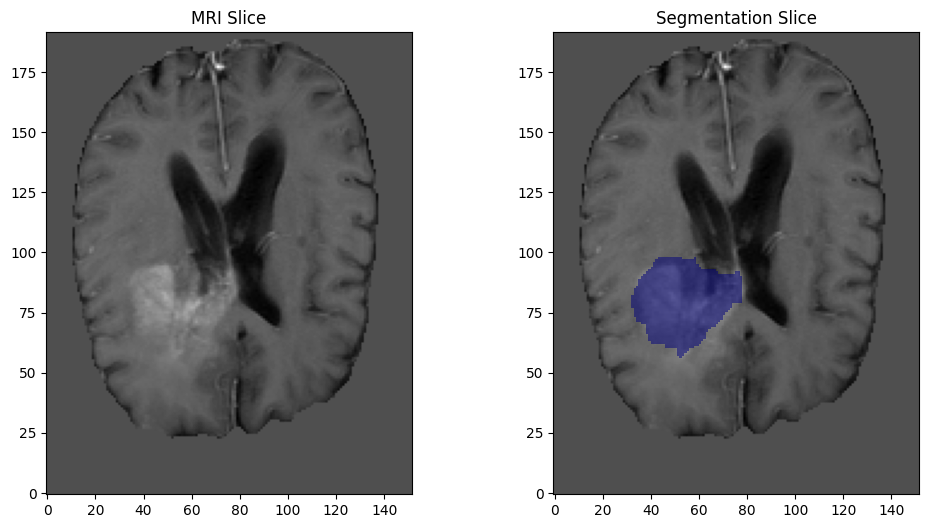

In [157]:
# load GT segmentation as NII object
gt_path = bids_ds.bids_list[0]['seg']
gt = NII.load(gt_path.with_suffix('.nii.gz'), seg=True)

gt : NII = gt.set_array(sample_gt.squeeze(0).numpy())

rebinarized_gt = torch.argmax(sample_soft_gt, dim = 0).numpy()
rebinarized_nii: NII = gt.set_array(rebinarized_gt)  # get prediction as nii object

difference_nifti = NII.get_segmentation_difference_to(rebinarized_nii, gt, ignore_background_tp=True)
difference_array = difference_nifti.get_array()
print(f"Unique Values and counts: {np.unique(difference_array, return_counts=True)}")
print("Difference NII (0: BG, 1: FN, 2: TP, 3: FP, 4: Wrong label)")
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(difference_array, axis))

# Sigma 0.5

## Pure

In [10]:
dilate = 0
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.5, do2D = False, soft=False, dilate=dilate, binary=False, ds_factor=None, experiment = 1)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [14]:
idx = 0
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

### Looking at unique values of soft Mask

In [160]:
# Without any processing
print_unique_etc(sample_soft_gt)

unique values in soft gt: tensor([0.0000e+00, 1.8372e-11, 3.6743e-11,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
unique sums across all channels (metatensor([1.0000, 1.0000, 1.0000]), metatensor([   4231, 4198232,      33]))


In [161]:
# Without any processing
print_unique_etc(sample_soft_gt.round(decimals=2))

unique values in soft gt: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400, 0.5500, 0.5600, 0.5700,
        0.5800, 0.5900, 0.6000, 0.6100, 0.6200, 0.6300, 0.6400, 0.6500, 0.6600,
        0.6700, 0.6800, 0.6900, 0.7000, 0.7100, 0.7200, 0.7300, 0.7400, 0.7500,
        0.7600, 0.7700, 0.7800, 0.7900, 0.8000, 0.8100, 0.8200, 0.8300, 0.8400,
        0.8500, 0.8600, 0.8700, 0.8800, 0.8900, 0.9000, 0.9100, 0.9200, 0.9300,
        0.9400, 0.9500, 0.9600, 0.9700, 0.9800, 0.9900, 1.0000])
unique sums across all channels (metatensor([0.9900, 0.9900, 0.9900, 1.0000, 1.0000, 1.0000, 1.0100, 1.0100])

### Plots

#### Plot Hard GTs

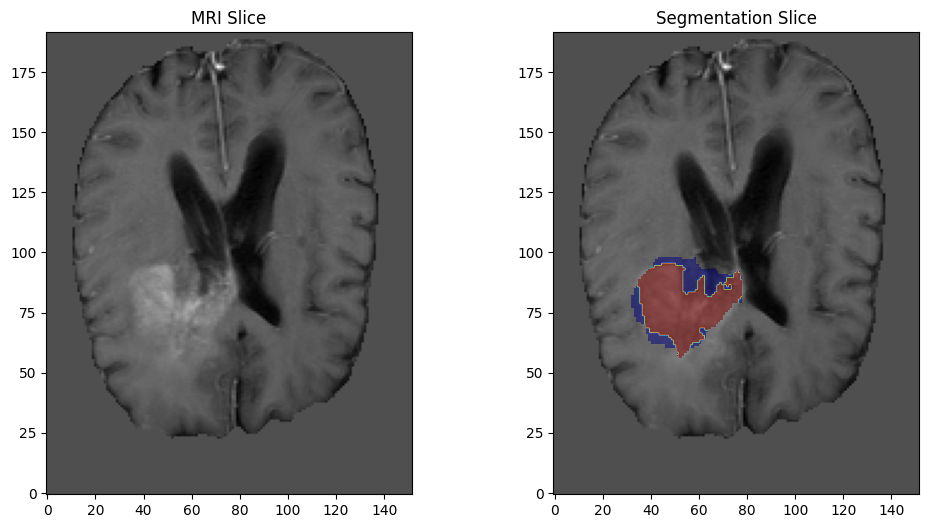

In [15]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

#### Plot Soft GTs

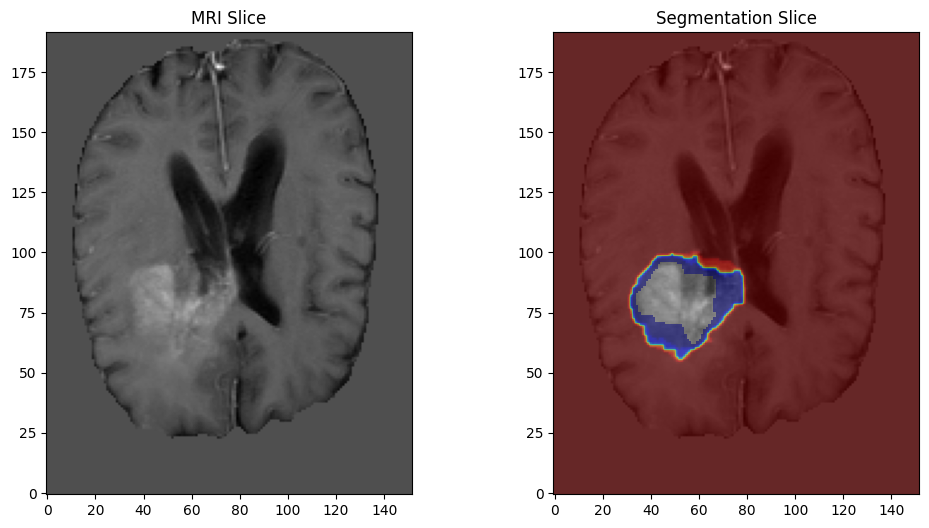

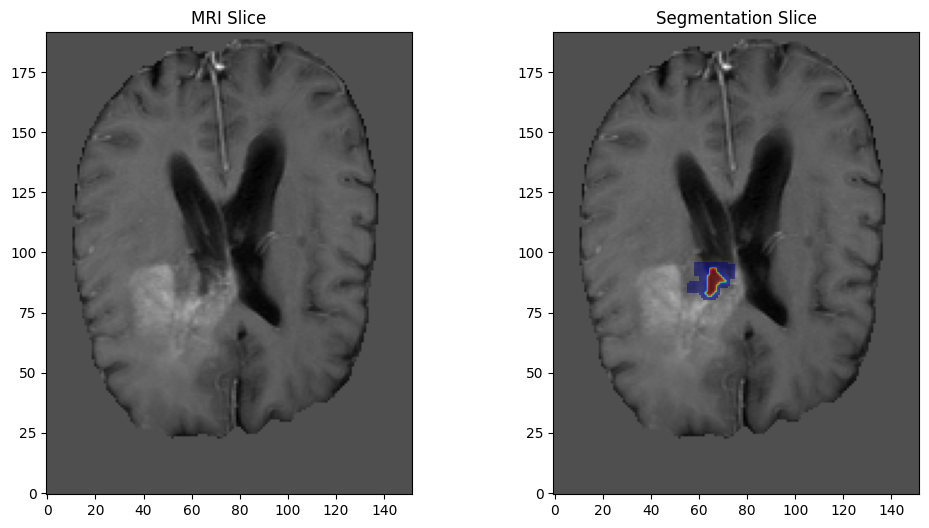

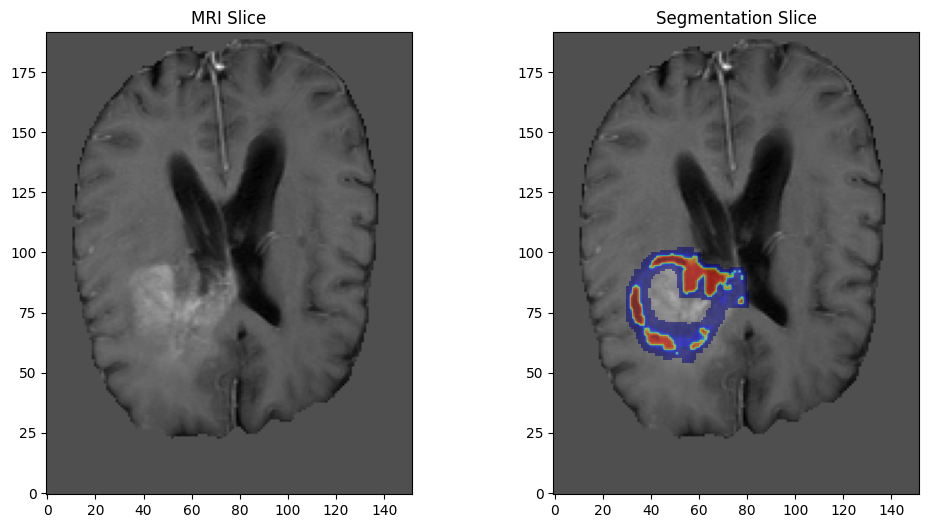

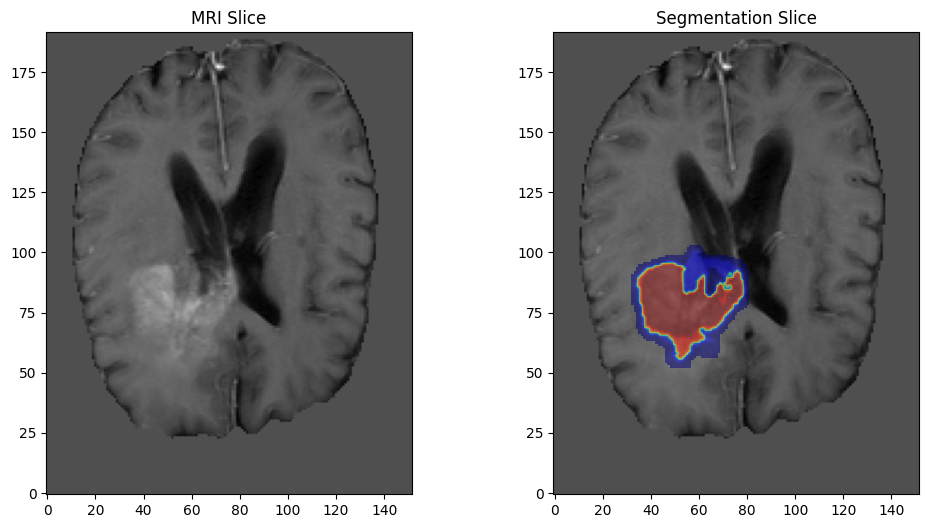

In [16]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[3], axis))

#### Plot Difference between GT and rebinarized Soft_GT

Unique Values and counts: (array([0, 2, 4]), array([4065620,  136875,       1]))
Difference NII (0: BG, 1: FN, 2: TP, 3: FP, 4: Wrong label)


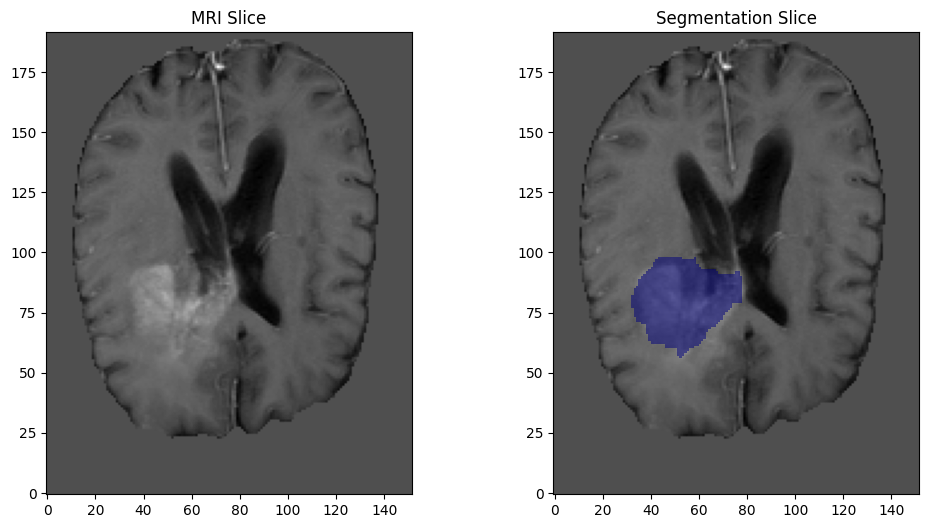

In [18]:
# load GT segmentation as NII object
gt_path = bids_ds.bids_list[0]['seg']
gt = NII.load(gt_path.with_suffix('.nii.gz'), seg=True)

gt : NII = gt.set_array(sample_gt.squeeze(0).numpy())

rebinarized_gt = torch.argmax(sample_soft_gt, dim = 0).numpy()
rebinarized_nii: NII = gt.set_array(rebinarized_gt)  # get prediction as nii object

difference_nifti = NII.get_segmentation_difference_to(rebinarized_nii, gt, ignore_background_tp=True)
difference_array = difference_nifti.get_array()
print(f"Unique Values and counts: {np.unique(difference_array, return_counts=True)}")
print("Difference NII (0: BG, 1: FN, 2: TP, 3: FP, 4: Wrong label)")
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(difference_array, axis))

In [19]:
###